In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow import keras
from keras.applications import MobileNetV2
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.datasets import cifar100

from keras_tuner import RandomSearch

8. I denna uppgift arbetar vi med CIFAR-100 datasetet som gicks igenom i kodexempel 1. 

Hämtar CIFAR-100 datasetet och delar upp det i tränings och testdata.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

c:\Users\genc-\Downloads\Desktop\Skola\11-ai-teori-och-tillämpning-del-2\kunskapskontroll_del1\.venv\Lib\site-packages\keras\src\datasets\cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Datasetet är väldigt stort och det tar för lång tid att träna på hela datamängden. Därför begränsas antalet datapunkter till 5000.

In [3]:
limit = 5000
x_train = x_train[:limit]
x_test = x_test[:limit]
y_train = y_train[:limit]
y_test = y_test[:limit]

Normaliserar pixlarna genom att divivdera x_train och x_test med 255.

In [4]:
X_train = x_train / 255.0
X_test = x_test / 255.0

Printar ut formen på all data.

In [5]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (5000, 32, 32, 3)
X_test:  (5000, 32, 32, 3)
y_train:  (5000, 1)
y_test:  (5000, 1)


Loopar igenom de 9 första bilder.

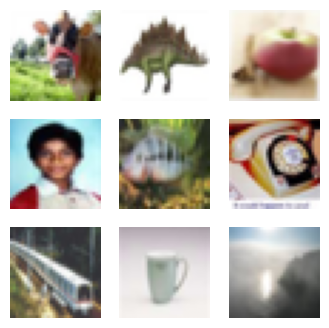

In [6]:
plt.figure(figsize=(4,4))
for i in range(9):
    plt.subplot(3,3, i + 1)
    plt.imshow(X_train[i])
    plt.axis('off')

a) Skapa en CNN-modell för att prediktera datasetet. 

Bygger CNN-modell med flera konvolutions och poolinglager som avslutas med täta lager för bildklassificering i 100 klasser. Relu används som aktiveringsfunktion i de dolda lagren.

In [7]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(100, activation='softmax'))

c:\Users\genc-\Downloads\Desktop\Skola\11-ai-teori-och-tillämpning-del-2\kunskapskontroll_del1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Kompilerar modellen så att den är redo att tränas.

In [8]:
model1.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Tränar modellen.

In [9]:
history = model1.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose=2)

Epoch 1/10
32/32 - 3s - 94ms/step - accuracy: 0.0110 - loss: 4.6058 - val_accuracy: 0.0160 - val_loss: 4.5937
Epoch 2/10
32/32 - 2s - 57ms/step - accuracy: 0.0223 - loss: 4.5299 - val_accuracy: 0.0240 - val_loss: 4.4772
Epoch 3/10
32/32 - 2s - 58ms/step - accuracy: 0.0268 - loss: 4.4021 - val_accuracy: 0.0220 - val_loss: 4.5176
Epoch 4/10
32/32 - 7s - 225ms/step - accuracy: 0.0432 - loss: 4.2957 - val_accuracy: 0.0280 - val_loss: 4.3700
Epoch 5/10
32/32 - 8s - 246ms/step - accuracy: 0.0500 - loss: 4.2061 - val_accuracy: 0.0280 - val_loss: 4.2719
Epoch 6/10
32/32 - 4s - 130ms/step - accuracy: 0.0540 - loss: 4.1238 - val_accuracy: 0.0410 - val_loss: 4.2203
Epoch 7/10
32/32 - 5s - 158ms/step - accuracy: 0.0670 - loss: 4.0285 - val_accuracy: 0.0440 - val_loss: 4.3075
Epoch 8/10
32/32 - 4s - 122ms/step - accuracy: 0.0833 - loss: 3.9492 - val_accuracy: 0.0820 - val_loss: 4.0873
Epoch 9/10
32/32 - 4s - 119ms/step - accuracy: 0.0938 - loss: 3.8483 - val_accuracy: 0.0950 - val_loss: 3.9417
Epoc

Utvärdering av modellen genom att beräkna accuracy på testdatan.

In [10]:
y_pred = model1.predict(X_test, verbose=2)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred_labels == y_test.flatten())
print(f"Accuracy: {accuracy}")

157/157 - 1s - 8ms/step
Accuracy: 0.0802


Resultatet är inte så givande eftersom datamängden är begränsad.

b) Om du justerar hyperparametrar med *KerasTuner*, får du bättre resultat? 

En Keras CNN-modell byggs där antalet konvolutionslager, filter, neuroner och learning rate är justerbara för att hitta de bästa hyperparametrarna.

In [11]:
def build_model(hp):
    model2 = Sequential()
    model2.add(Input(shape=(32,32,3)))

    for i in range(hp.Int('conv_layers', 2, 4)):
        model2.add(Conv2D(
            filters=hp.Choice(f'filters_{i}', [32, 64, 128]),
            kernel_size=3,
            activation='relu',
            padding='same'
        ))
        model2.add(MaxPooling2D())

    model2.add(Flatten())

    model2.add(Dense(
        units=hp.Int('units', 128, 512, step=128),
        activation='relu'
    ))

    model2.add(Dense(100, activation='softmax'))

    model2.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model2

En tuner som söker efter de bästa hyperparametrarna för modellen med Random Search.

In [12]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory=r"C:\cifar_tuner",
    project_name="cifar_randomsearch",
)

Tunern tränar modellen i 5 epoker och har en validation-split på 0.1.

In [13]:
tuner.search(
    X_train,
    y_train,
    epochs = 5,
    validation_split=0.1
)

Trial 10 Complete [00h 00m 18s]
val_accuracy: 0.15399999916553497

Best val_accuracy So Far: 0.16599999368190765
Total elapsed time: 00h 03m 04s


Hämtar den bästa modellen.

In [14]:
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\genc-\Downloads\Desktop\Skola\11-ai-teori-och-tillämpning-del-2\kunskapskontroll_del1\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Tränar modellen med de bästa hyperparametrarna.

In [15]:
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5775 - loss: 1.6077 - val_accuracy: 0.3720 - val_loss: 2.8173
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7300 - loss: 1.0353 - val_accuracy: 0.3610 - val_loss: 3.1082
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8213 - loss: 0.6804 - val_accuracy: 0.3500 - val_loss: 3.3880
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8845 - loss: 0.4405 - val_accuracy: 0.3420 - val_loss: 3.7373
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9240 - loss: 0.3133 - val_accuracy: 0.3140 - val_loss: 4.1889
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9482 - loss: 0.2091 - val_accuracy: 0.3080 - val_loss: 4.5046
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9628 - loss: 0.1633 - val_accuracy: 0.3040 - val_loss: 4.8091
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9762 - loss: 0.1071 - val_accu

Utvärderar tuner-modellen på testdata.

In [16]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1860 - loss: 7.3270


Med KerasTuner ökar accuracy, vilket ger en bättre modell.

c) Prova använd *transfer learning* för att genomföra prediktioner, får du bättre resultat? 

Här skalas tränings och testbilderna om till 128×128 pixlar för att passa modellens indata.

In [17]:
X_train = tf.image.resize(X_train, (128,128))
X_test = tf.image.resize(X_test, (128,128))

Använder en förtränad modell som heter MobileNetV2.

In [18]:
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base.trainable = False

In [19]:
model3 = Sequential([
    base,
    Flatten(),
    Dense(100, activation='softmax')
])

Kompilerar modellen så att den är redo att tränas.

In [20]:
model3.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Tränar modellen i tio epoker med en validation-split på 0.2.

In [21]:
model3.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=2)

Epoch 1/10
125/125 - 22s - 173ms/step - accuracy: 0.1855 - loss: 11.8250 - val_accuracy: 0.2790 - val_loss: 7.7323
Epoch 2/10
125/125 - 28s - 226ms/step - accuracy: 0.5260 - loss: 3.9467 - val_accuracy: 0.3280 - val_loss: 8.2810
Epoch 3/10
125/125 - 54s - 430ms/step - accuracy: 0.7160 - loss: 1.9257 - val_accuracy: 0.3100 - val_loss: 9.6800
Epoch 4/10
125/125 - 35s - 281ms/step - accuracy: 0.8305 - loss: 1.0494 - val_accuracy: 0.3290 - val_loss: 9.1568
Epoch 5/10
125/125 - 40s - 316ms/step - accuracy: 0.8865 - loss: 0.5811 - val_accuracy: 0.3420 - val_loss: 8.9578
Epoch 6/10
125/125 - 44s - 351ms/step - accuracy: 0.9243 - loss: 0.3702 - val_accuracy: 0.3390 - val_loss: 9.8864
Epoch 7/10
125/125 - 38s - 306ms/step - accuracy: 0.9475 - loss: 0.2522 - val_accuracy: 0.3610 - val_loss: 9.3555
Epoch 8/10
125/125 - 39s - 315ms/step - accuracy: 0.9570 - loss: 0.1890 - val_accuracy: 0.3680 - val_loss: 9.0846
Epoch 9/10
125/125 - 39s - 314ms/step - accuracy: 0.9690 - loss: 0.1434 - val_accuracy:

Utvärderar modellen på testdata.

In [22]:
y_pred = model3.predict(X_test, verbose=2)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred_labels == y_test.flatten())
print(f"Accuracy: {accuracy}")

157/157 - 18s - 116ms/step
Accuracy: 0.3922


Med transfer learning är resultatet högst eftersom den förtränade modellen redan har lärt sig bildmönster från imageNet. 

Bäst resultat : 1) Transfer learning 2) KerasTuner 3) Vanlig CNN